In [1]:
#imports

import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf

# hs to force keras to use tensorflow
os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K



#Data generation/Augmentation with keras
#from keras.preprocessing.image import ImageDataGenerator

# data augmentation with imaug
import imgaug as ia
from imgaug import augmenters as iaa
import imageio
import numpy as np

ia.seed(1337)



# for logging
from time import time
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [3]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [4]:
# Set some global parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


# final training set
X_train_final_augmented = np.zeros((0, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train_final_augmented = np.zeros((0, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# <font color='blue'> Loading and Augmenting the data

In [7]:
# Get and resize ORIGNAL LENGTH (to be highly augmented later) train images and masks

TRAIN_PATH_fullSize = '/media/hooman/hsSsdPartUbuntu/FM_PROJECT/dataPreparation/FMDL_3.1/backhoe/fmdl-backhoe-trainingData-new_may10-2019/images_fromJira/'

MASK_PATH_fullSize  = '/media/hooman/hsSsdPartUbuntu/FM_PROJECT/dataPreparation/FMDL_3.1/backhoe/fmdl-backhoe-trainingData-new_may10-2019/masks_full/'

train_ids_fullSize = os.listdir(MASK_PATH_fullSize)

X_train_fullSize = np.zeros((len(train_ids_fullSize), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train_fullSize = np.zeros((len(train_ids_fullSize), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for n, fileName in tqdm(enumerate(train_ids_fullSize), total=len(train_ids_fullSize)):
    img = imread(TRAIN_PATH_fullSize + fileName)[:,:,:IMG_CHANNELS]
    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train_fullSize[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    mask_ = imread(MASK_PATH_fullSize + fileName )

    #expand dim just converts the (h,w,) image to (h,w,1) look at above for experimentation with np.expand_dim
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                  preserve_range=True), axis=-1)

    #hs this in effect adds all the masks together into one mask of the same size.Since masks are bindary.
    mask = np.maximum(mask, mask_)
    Y_train_fullSize[n] = mask

100%|██████████| 3899/3899 [00:47<00:00, 82.67it/s]


In [8]:
# Get and resize CROPPED2BUCKET (No augmentation) train images and masks AND ADD them to the FINAL augmented set


TRAIN_PATH_cropped = '/media/hooman/hsSsdPartUbuntu/FM_PROJECT/dataPreparation/FMDL_3.1/backhoe/fmdl-backhoe-trainingData-new_may10-2019/images_cropped/'
MASK_PATH_cropped  = '/media/hooman/hsSsdPartUbuntu/FM_PROJECT/dataPreparation/FMDL_3.1/backhoe/fmdl-backhoe-trainingData-new_may10-2019/masks_cropped/'

train_ids_cropped = os.listdir(MASK_PATH_cropped)

for n, fileName in tqdm(enumerate(train_ids_cropped), total=len(train_ids_cropped)):
    img = imread(TRAIN_PATH_cropped + fileName)[:,:,:IMG_CHANNELS]
    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train_final_augmented = np.concatenate((X_train_final_augmented, img[np.newaxis,...].astype(np.uint8)), axis=0)
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    mask_ = imread(MASK_PATH_cropped + fileName )

    #expand dim just converts the (h,w,) image to (h,w,1) look at above for experimentation with np.expand_dim
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                  preserve_range=True), axis=-1)

    #hs this in effect adds all the masks together into one mask of the same size.Since masks are bindary.
    mask = np.maximum(mask, mask_)
    Y_train_final_augmented = np.concatenate((Y_train_final_augmented, mask[np.newaxis,...]), axis=0)

100%|██████████| 3899/3899 [03:06<00:00, 20.93it/s]


In [ ]:
# augment the images with original size X_train_fullSize and Y_train_fullSize


#some augs are defined here rest just inlne
cropAug = iaa.Sequential([
    iaa.CropAndPad(
    percent=(-0.3, 0.3),
    pad_mode=["edge"]),
], random_order=False)


scaleAug = iaa.Sequential([
    iaa.Scale((0.5, 1.0)),
], random_order=False)


rotateAug = iaa.Sometimes(0.5, iaa.Affine(rotate=(-10, 10)))

dropOutAug = iaa.Sometimes(0.5, iaa.Dropout([0.05, 0.1]))

pixelValAddAug = iaa.Sometimes(0.5, iaa.Add((-40,40)))

sharpenAug = iaa.Sometimes(0.2, iaa.Sharpen(alpha=(0.05, 0.2)))

contrastNormAug = iaa.Sometimes(0.2, iaa.ContrastNormalization((0.5, 1.5)))



#Actually augment
for i, _ in tqdm(enumerate(train_ids_fullSize), total=len(train_ids_fullSize)):
    #get current image and segmap and add them to the set
    image = X_train_fullSize[i]
    segmap = Y_train_fullSize[i]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, image[np.newaxis,...]), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, segmap[np.newaxis,...]), axis=0)

    #convert to imaug's segmap class
    segmap = ia.SegmentationMapOnImage(segmap, shape=image.shape, nb_classes=1+1)


    # X translation
    augResIm = iaa.Affine(translate_px={"x":-5}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"x":-5}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)

    augResIm = iaa.Affine(translate_px={"x":-10}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"x":-10}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)

    augResIm = iaa.Affine(translate_px={"x":-15}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"x":-15}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)


    augResIm = iaa.Affine(translate_px={"x":5}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"x":5}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)


    augResIm = iaa.Affine(translate_px={"x":10}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"x":10}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)


    augResIm = iaa.Affine(translate_px={"x":15}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"x":15}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)



    # Y translation
    augResIm = iaa.Affine(translate_px={"y":5}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"y":5}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)


    augResIm = iaa.Affine(translate_px={"y":10}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"y":10}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)

    augResIm = iaa.Affine(translate_px={"y":15}).augment_image(image)
    augResMask = iaa.Affine(translate_px={"y":15}).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)

    #horizantal flip
    augResIm = iaa.Fliplr(1).augment_image(image)
    augResMask = iaa.Fliplr(1).augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)


    #Random crop
    cropAug_det = cropAug.to_deterministic()
    augResIm = cropAug_det.augment_image(image)
    augResMask = cropAug_det.augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)



    #Random rotate or elastically transform
    rotateAug_det = rotateAug.to_deterministic()
    augResIm = rotateAug_det.augment_image(image)
    augResMask = rotateAug_det.augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)

    #drop some pixels at random 50% of the time
    dropOutAug_det = dropOutAug.to_deterministic()
    augResIm = dropOutAug_det.augment_image(image)
    augResMask = dropOutAug_det.augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)


    # add rand nb between -40,40 to some pixels 50% of the time 
    pixelValAddAug_det = pixelValAddAug.to_deterministic()
    augResIm = pixelValAddAug_det.augment_image(image)
    augResMask = pixelValAddAug_det.augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)


    #sharpen images 20% of the time
    sharpenAug_det = sharpenAug.to_deterministic()
    augResIm = sharpenAug_det.augment_image(image)
    augResMask = sharpenAug_det.augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)


    #contrastNorm images 20% of the time
    contrastNormAug_det = contrastNormAug.to_deterministic()
    augResIm = contrastNormAug_det.augment_image(image)
    augResMask = contrastNormAug_det.augment_segmentation_maps([segmap])[0]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, augResIm[np.newaxis,...].astype(np.uint8)), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, augResMask.get_arr_int()[np.newaxis,...,np.newaxis].astype(np.bool)), axis=0)

    
    
# free the memory because these are already in final augmented set
del X_train_fullSize
del Y_train_fullSize

In [9]:
# If NOT augmenting, add the original Length stuff
for i, _ in tqdm(enumerate(train_ids_fullSize), total=len(train_ids_fullSize)):
    #get current image and segmap and add them to the set
    image = X_train_fullSize[i]
    segmap = Y_train_fullSize[i]
    X_train_final_augmented = np.concatenate( (X_train_final_augmented, image[np.newaxis,...]), axis=0)
    Y_train_final_augmented = np.concatenate( (Y_train_final_augmented, segmap[np.newaxis,...]), axis=0)

100%|██████████| 3899/3899 [08:22<00:00,  5.81it/s]


In [10]:
# hs shuffle the training data to randomize it 
s = np.arange(X_train_final_augmented.shape[0])
np.random.shuffle(s)

X_train_final_augmented = X_train_final_augmented[s, :, :,:]
Y_train_final_augmented = Y_train_final_augmented[s, :, :,:]

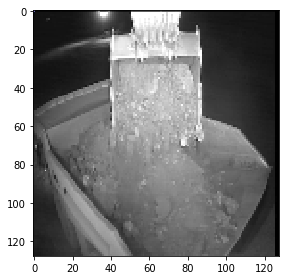

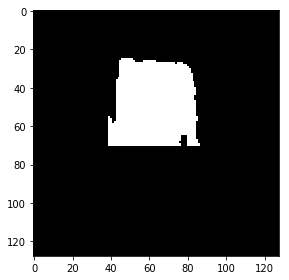

In [11]:
# Check if training data looks all right
ix = random.randint(0, 50)
imshow(X_train_final_augmented[ix])
plt.show()
imshow(np.squeeze(Y_train_final_augmented[ix]))
plt.show()

# <font color='blue'> Model Definitions

## My U-Net


![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [5]:
## hsUnet single class on cropped images resized to 128*128
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

*Update: Changed to ELU units, added dropout.*
*Update: Added early stopping and checkpointing and increased to 30 epochs.*

In [ ]:
# Unload the model off the GPU without restarting the kernel (So that your training data remains loaded)
K.clear_session()
del model

import gc
gc.collect()

# <font color='blue'> Training without Aug

In [12]:
# Fit model. I trained my models with batch_size=64 but vesUNet can only be trained with 32 apparently
tensorboard = TensorBoard(log_dir="/media/hooman/hsSsdPartUbuntu/FM_PROJECT/FMDL_3.1/backhoe/UNET/try1/trainingLogs/{}".format(time()))

earlystopper = EarlyStopping(patience=51, verbose=1)

#check points everytime val_loss improves without overrides.
bestModelCheckpointer = ModelCheckpoint('/media/hooman/hsSsdPartUbuntu/FM_PROJECT/FMDL_3.1/backhoe/UNET/try1/backhoe-hsUNet-try1-bestModel_epoch-{epoch:02d}_valLoss-{val_loss:.2f}.h5', verbose=1, save_best_only=True)


#check points every 10 epochs
#regularModelCheckpointer = ModelCheckpoint('/home/hooman/sdc1Storage/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try1__newDataAndNewAug__restSameNetworkAs_try21_1chan_roiDelineatorVersion-1/movelsSavedEvery10ep/model-hsUNet-try1-regularModel_epoch-{epoch:02d}_valLoss-{val_loss:.2f}.h5', verbose=1, save_best_only=False, period=10)


results = model.fit(X_train_final_augmented, Y_train_final_augmented, validation_split=0.02, batch_size=64, epochs=500, callbacks=[earlystopper, bestModelCheckpointer, tensorboard])

Train on 7642 samples, validate on 156 samples
Epoch 1/500
7642/7642 [==============================] - 14s 2ms/step - loss: 0.3700 - mean_iou: 0.4290 - val_loss: 0.3298 - val_mean_iou: 0.4348

Epoch 00001: val_loss improved from inf to 0.32977, saving model to /media/hooman/hsSsdPartUbuntu/FM_PROJECT/FMDL_3.1/backhoe/UNET/try1/backhoe-hsUNet-try1-bestModel_epoch-01_valLoss-0.33.h5
Epoch 2/500
7642/7642 [==============================] - 11s 1ms/step - loss: 0.3081 - mean_iou: 0.4366 - val_loss: 0.2746 - val_mean_iou: 0.4397

Epoch 00002: val_loss improved from 0.32977 to 0.27458, saving model to /media/hooman/hsSsdPartUbuntu/FM_PROJECT/FMDL_3.1/backhoe/UNET/try1/backhoe-hsUNet-try1-bestModel_epoch-02_valLoss-0.27.h5
Epoch 3/500
7642/7642 [==============================] - 11s 1ms/step - loss: 0.2445 - mean_iou: 0.4544 - val_loss: 0.1886 - val_mean_iou: 0.4772

Epoch 00003: val_loss improved from 0.27458 to 0.18856, saving model to /media/hooman/hsSsdPartUbuntu/FM_PROJECT/FMDL_3.1/back

7642/7642 [==============================] - 12s 2ms/step - loss: 0.0281 - mean_iou: 0.8463 - val_loss: 0.0873 - val_mean_iou: 0.8476

Epoch 00034: val_loss did not improve from 0.06654
Epoch 35/500
7642/7642 [==============================] - 12s 2ms/step - loss: 0.0269 - mean_iou: 0.8489 - val_loss: 0.0921 - val_mean_iou: 0.8502

Epoch 00035: val_loss did not improve from 0.06654
Epoch 36/500
7642/7642 [==============================] - 11s 1ms/step - loss: 0.0267 - mean_iou: 0.8514 - val_loss: 0.0930 - val_mean_iou: 0.8526

Epoch 00036: val_loss did not improve from 0.06654
Epoch 37/500
7642/7642 [==============================] - 11s 1ms/step - loss: 0.0265 - mean_iou: 0.8538 - val_loss: 0.0961 - val_mean_iou: 0.8549

Epoch 00037: val_loss did not improve from 0.06654
Epoch 38/500
7642/7642 [==============================] - 11s 1ms/step - loss: 0.0448 - mean_iou: 0.8559 - val_loss: 0.1060 - val_mean_iou: 0.8562

Epoch 00038: val_loss did not improve from 0.06654
Epoch 39/500
7642/

# <font color='blue'> Making Predictions

In [ ]:
# Get and resize valid images and masks

validation_images_path = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameNetworkAs_try21_1chan_roiDelineatorVersion-1/dataFor__hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/validation_images/'
validation_masks_path = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameNetworkAs_try21_1chan_roiDelineatorVersion-1/dataFor__hsUnet_try0_sameAs_try21_1chan_roiDelineatorVersion-1/validation_masks/'


TEST_PATH      = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/dataPreparation/hsTestSetOfHardImages/'
#TEST_MASK_PATH = '/home/hooman/dataPreparation/hsTestSet/cropped/croppedMasks_withInapp/'

test_ids = os.listdir(TEST_PATH)
print(len(test_ids))

valid_ids = os.listdir(validation_images_path)
print(len(valid_ids))



X_valid = np.zeros((len(valid_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_valid = np.zeros((len(valid_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for n, fileName in tqdm(enumerate(valid_ids), total=len(valid_ids)):
    img = imread(validation_images_path + fileName)[:,:,:IMG_CHANNELS]
    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_valid[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    mask_ = imread(validation_masks_path + fileName )

    #expand dim just converts the (h,w,) image to (h,w,1) look at above for experimentation with np.expand_dim
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                  preserve_range=True), axis=-1)

    #hs this in effect adds all the masks together into one mask of the same size.Since masks are bindary.
    mask = np.maximum(mask, mask_)
    Y_valid[n] = mask

In [11]:
# loading test data in a list
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for n, fileName in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imread(TEST_PATH + fileName)[:,:,:IMG_CHANNELS]
    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

100%|██████████| 100/100 [00:00<00:00, 103.32it/s]


0


/home/hooman/anaconda3/envs/unet/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/hooman/anaconda3/envs/unet/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


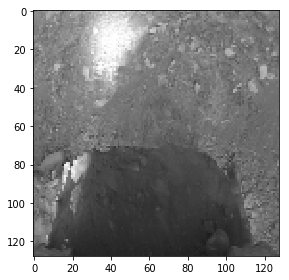

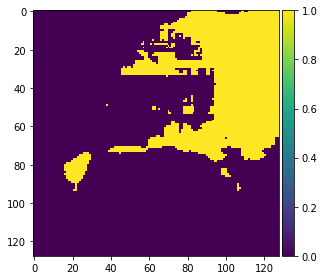

1


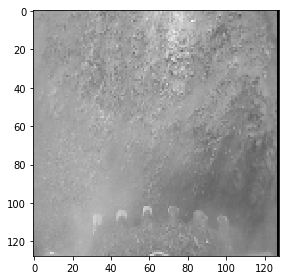

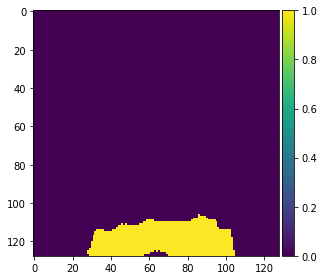

2


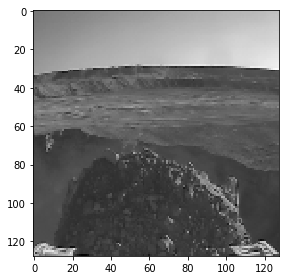

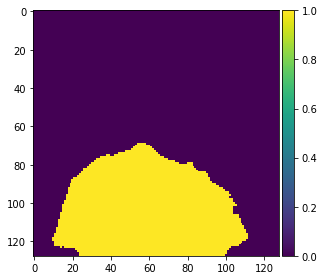

3


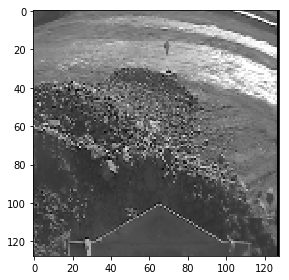

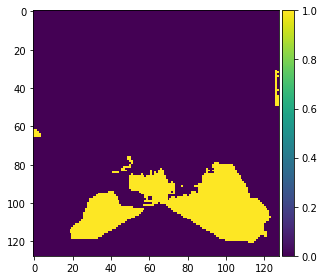

4


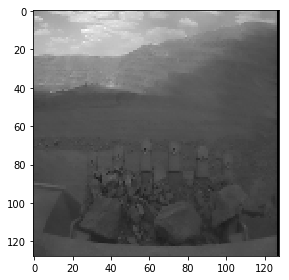

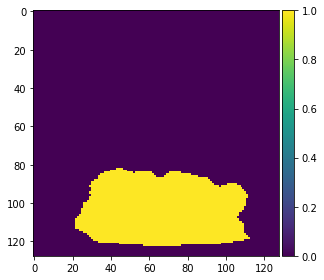

5


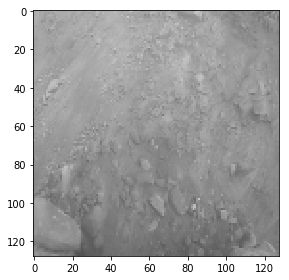

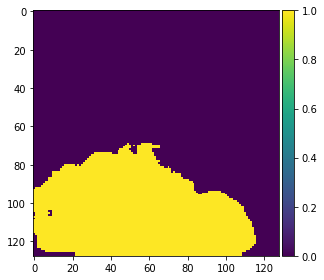

6


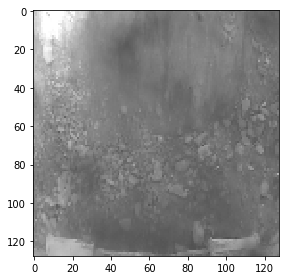

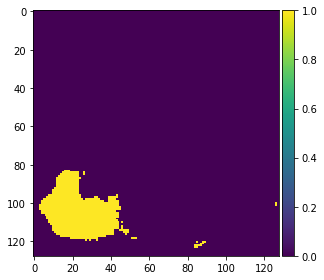

7


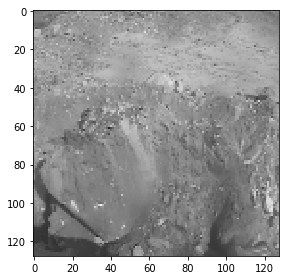

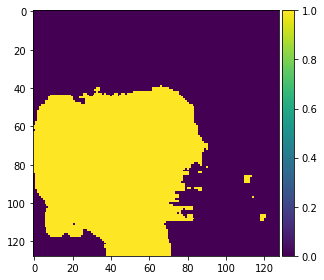

8


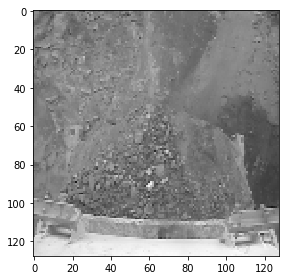

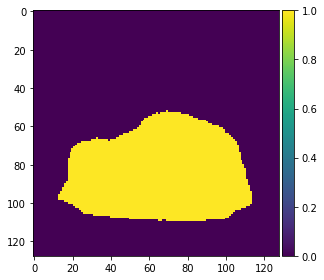

9


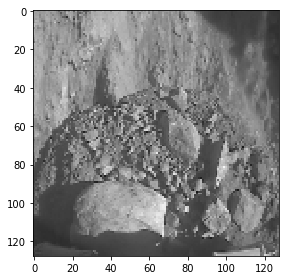

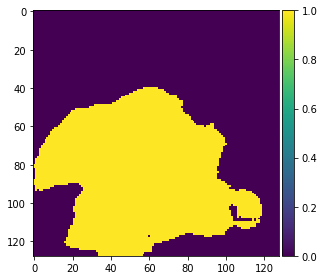

10


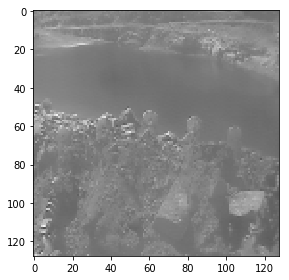

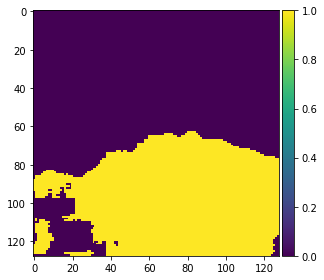

11


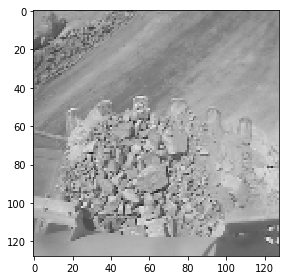

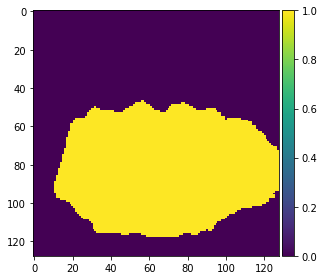

12


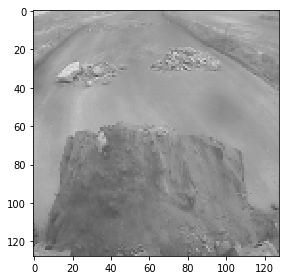

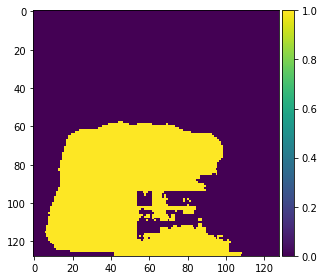

13


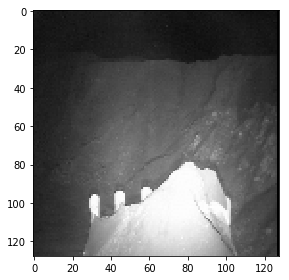

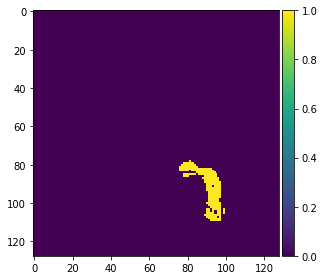

14


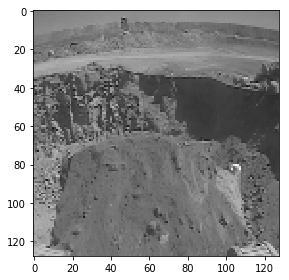

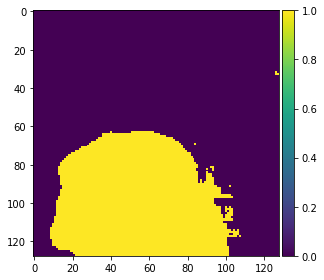

15


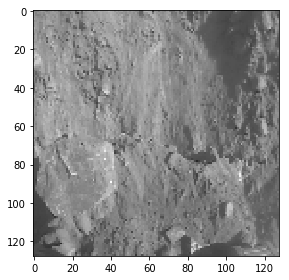

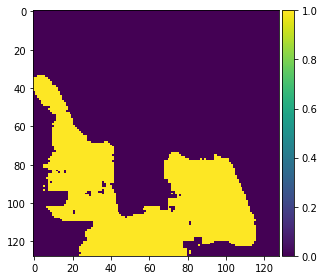

16


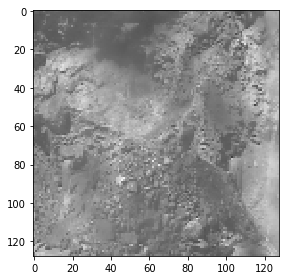

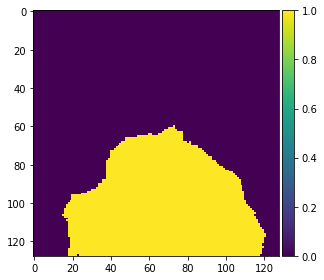

17


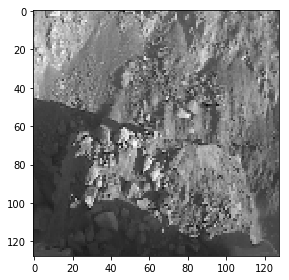

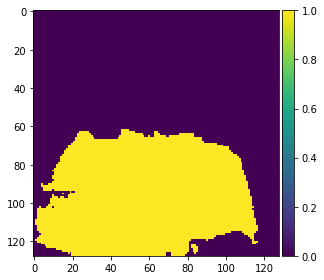

18


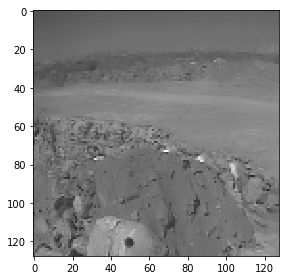

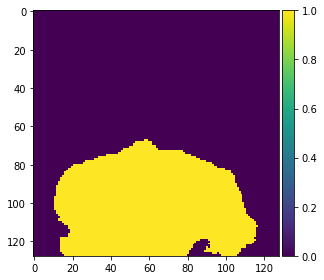

19


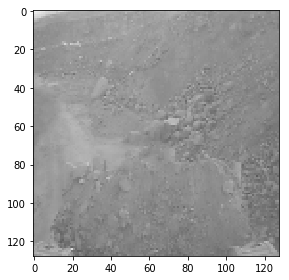

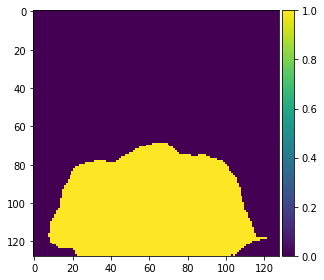

20


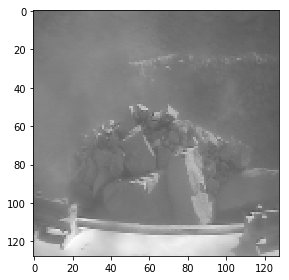

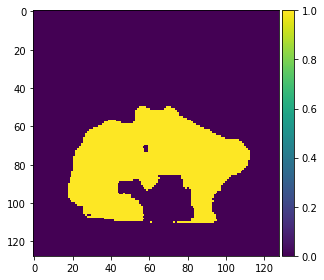

21


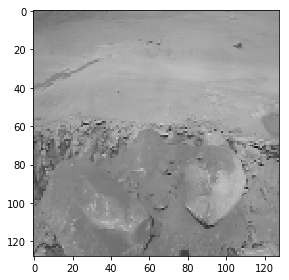

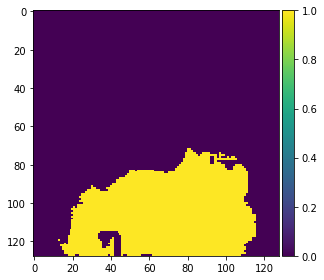

22


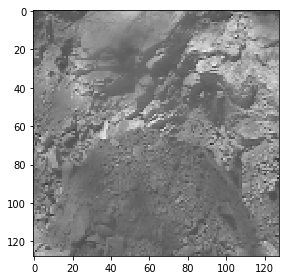

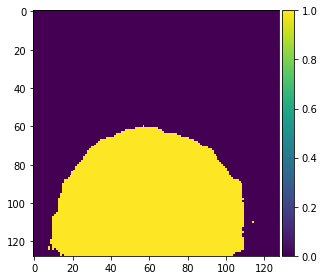

23


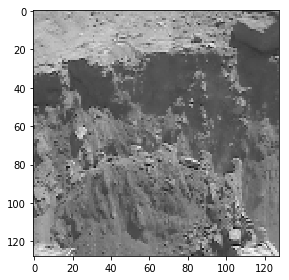

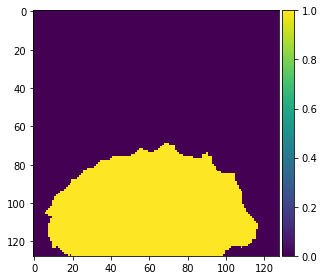

24


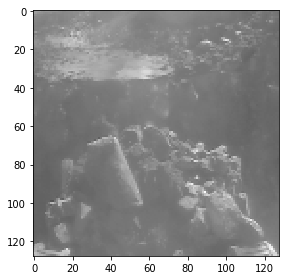

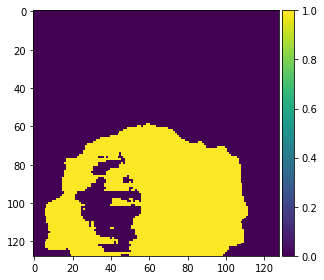

25


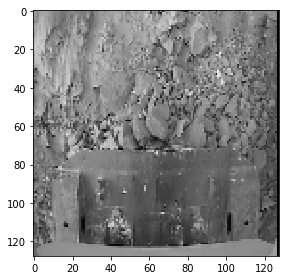

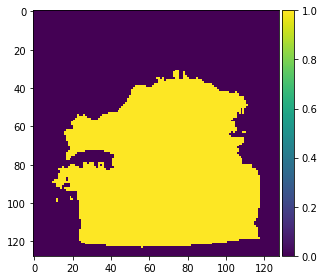

26


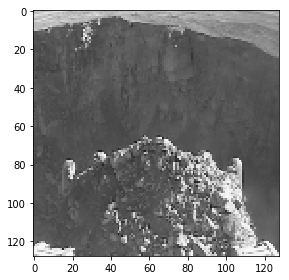

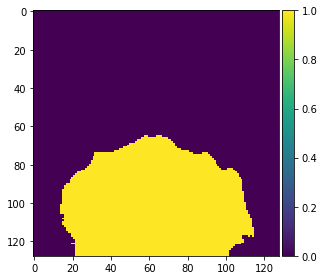

27


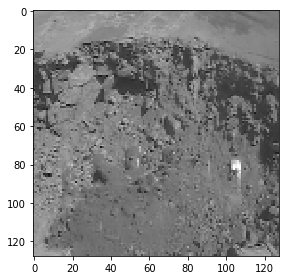

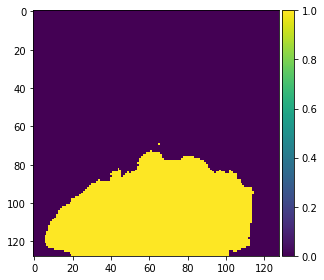

28


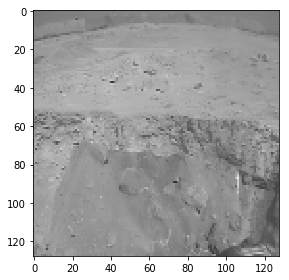

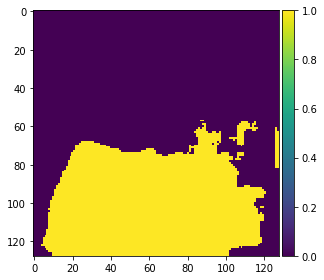

29


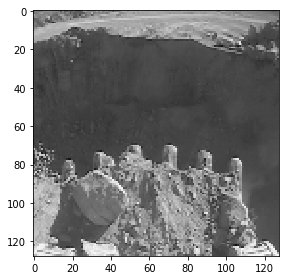

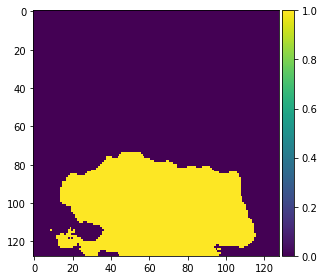

30


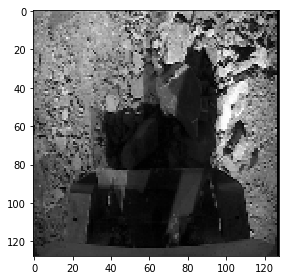

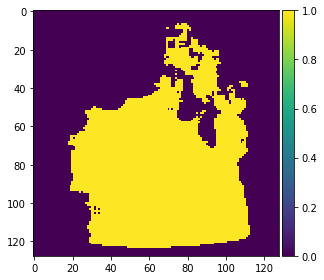

31


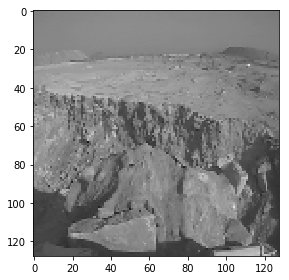

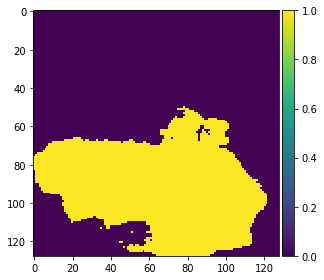

32


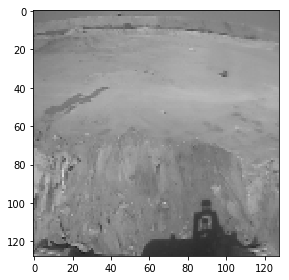

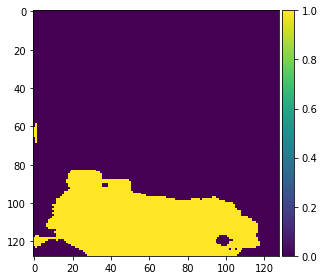

33


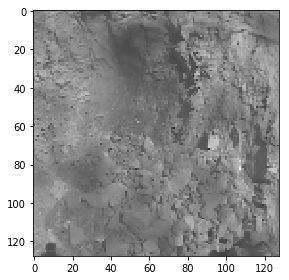

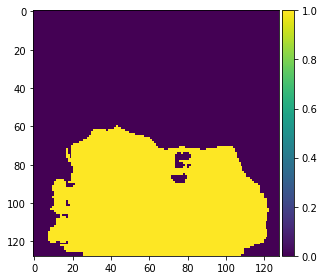

34


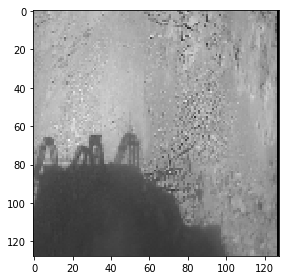

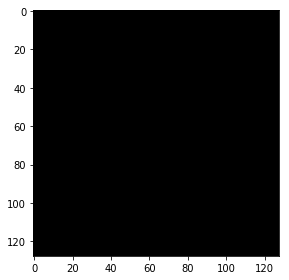

35


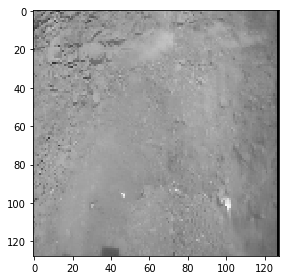

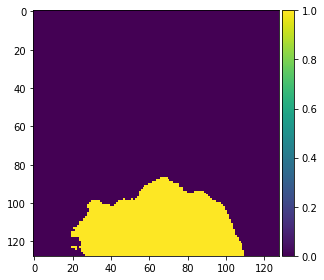

36


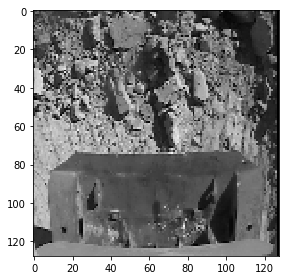

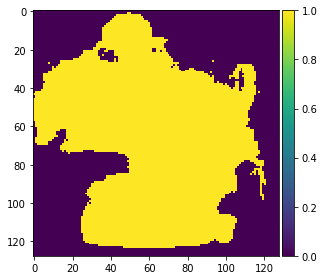

37


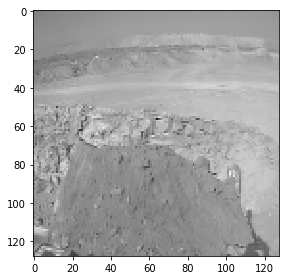

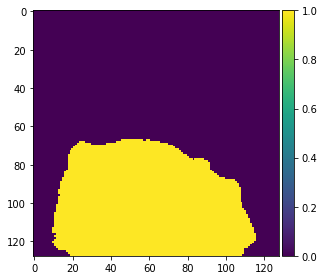

38


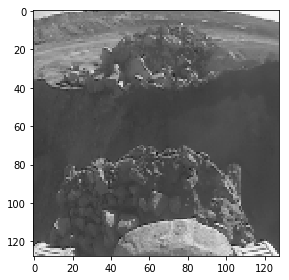

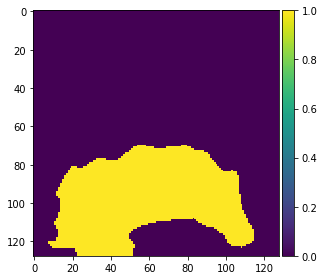

39


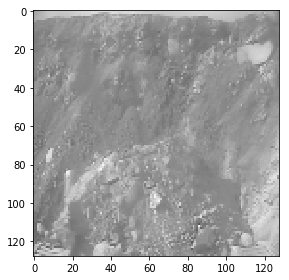

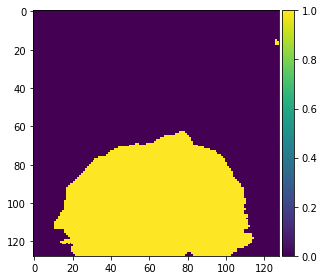

40


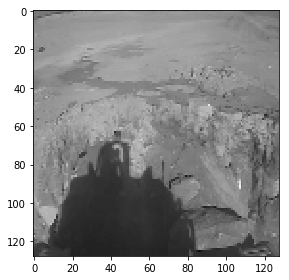

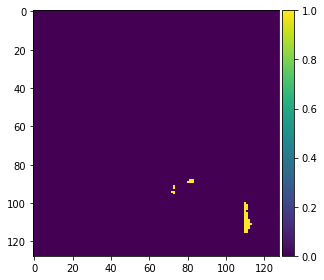

41


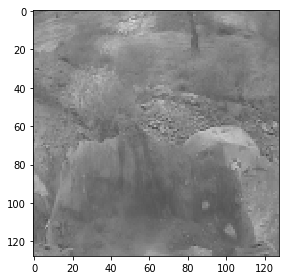

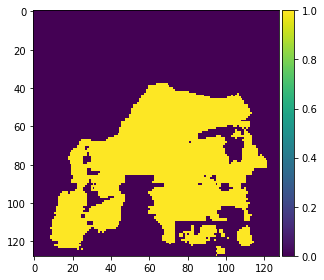

42


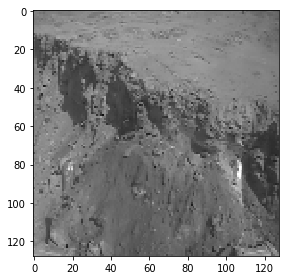

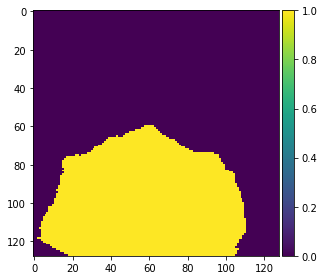

43


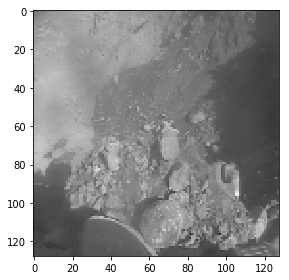

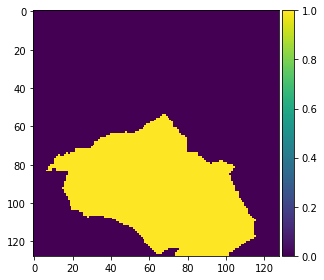

44


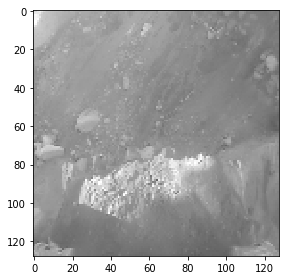

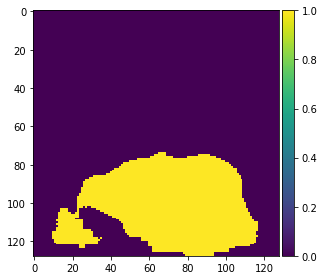

45


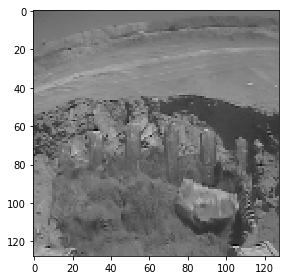

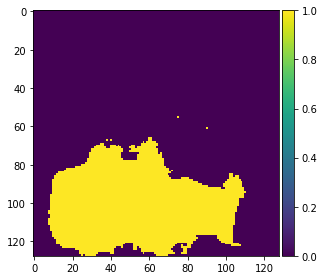

46


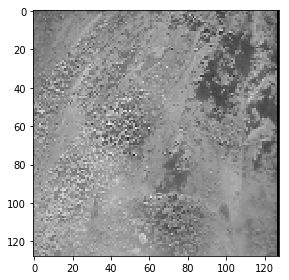

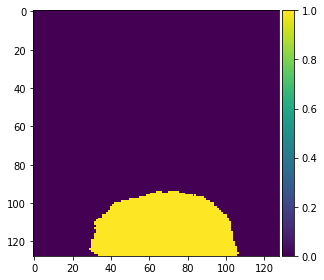

47


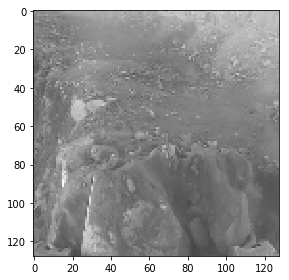

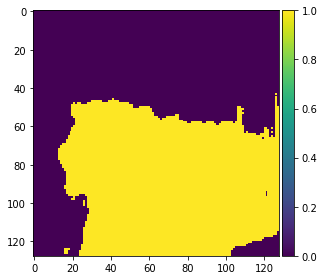

48


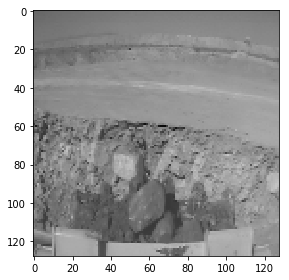

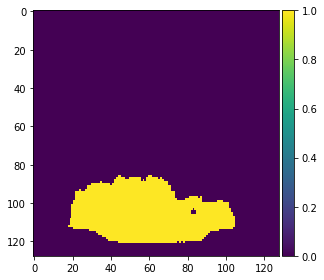

49


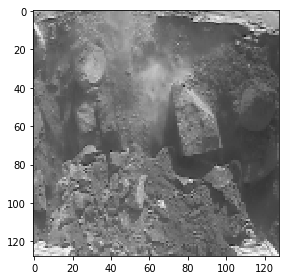

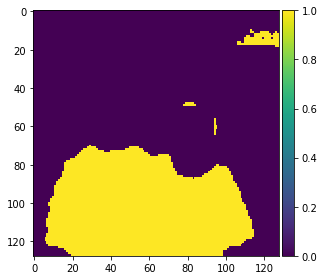

50


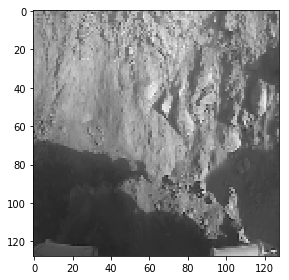

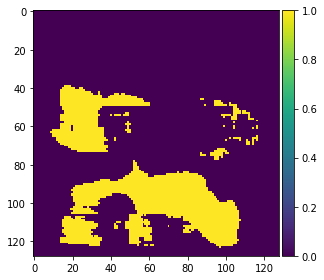

51


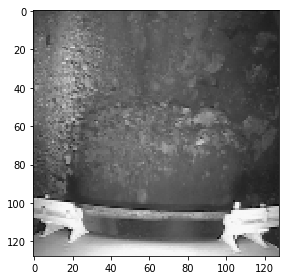

KeyboardInterrupt: 

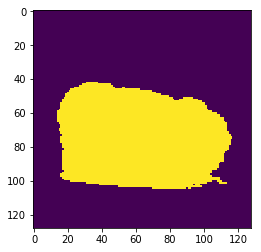

In [12]:
# making predictiosn from list in order to desplay

model = load_model('/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameNetworkAs_try21_1chan_roiDelineatorVersion-1/my_model.h5', custom_objects={'mean_iou': mean_iou})

pathToSavedResults = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameNetworkAs_try21_1chan_roiDelineatorVersion-1/preds-on-hsTestSetOfHardImages/'


testPreds = {}
testPreds_t = {}
for imgId in range(len(X_test)):
    testPreds[imgId] = model.predict(np.expand_dims(X_test[imgId], axis=0), verbose=0)
    testPreds_t[imgId] = (testPreds[imgId] > 0.5).astype(np.uint8)
    
    #imsave(pathToSavedResults + imgId, testPreds_t[imgId][0, :, :, 0])
    
    
    print(imgId)

    imshow(X_test[imgId])
    plt.show()
        
    imshow(testPreds_t[imgId][0,:,:, 0])
    plt.show()
    

In [25]:
# loading test data in a dictionary

testImages = {}
testLabels = {}

for n, fileName in tqdm(enumerate(test_ids), total=len(test_ids)):
    
    img = imread(TEST_PATH + fileName)
    testImages[fileName] = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #label = imread(TEST_MASK_PATH + fileName)
    #testLabels[fileName] = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    
print("loaded " + str(len(testImages)) + "  images and " + str(len(testLabels)) + " labels for testing")


100%|██████████| 100/100 [00:00<00:00, 101.89it/s]

loaded 100  images and 0 labels for testing


In [ ]:
# making predictiosn from dictionary in order to save the results to disk

model = load_model('hsUnet_try0_sameNetworkAs_try21_1chan_roiDelineatorVersion-1/model-hsUNet-try0-1chan.h5', custom_objects={'mean_iou': mean_iou})

pathToSavedResults = '/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameNetworkAs_try21_1chan_roiDelineatorVersion-1/preds-on-hsTestSetOfHardImages/'


testPreds = {}
testPreds_t = {}
for imgId in testImages:
    testPreds[imgId] = model.predict(np.expand_dims(testImages[imgId], axis=0), verbose=0)
    testPreds_t[imgId] = (testPreds[imgId] > 0.5).astype(np.uint8)
    
    #imsave(pathToSavedResults + imgId, testPreds_t[imgId][0, :, :, 0])
    
    
    print(imgId)

    imshow(testImages[imgId])
    plt.show()
        
    #imshow(testPreds_t[imgId][0,:,:, 0])
    #plt.show()
    

# <font color='blue'> Training with Keras data augmentation (not good)

In [18]:
#Training Generators

batchSize = 64
seed = 1

# we create two instances with the same arguments
data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.9,
                     height_shift_range=0.9,
                     brightness_range=[-100,100],
                     zoom_range=0.8,
                     shear_range=30,horizontal_flip=True)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(Y_train, augment=True, seed=seed)




image_generator = image_datagen.flow(
    X_train,
    batch_size=batchSize,
    seed=seed)

mask_generator = mask_datagen.flow(
    Y_train,
    batch_size=batchSize,
    seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

In [19]:
#validation Generators


# we create two instances with the same arguments
data_gen_args_valid = dict()

image_datagen_valid = ImageDataGenerator(**data_gen_args_valid)
mask_datagen_valid = ImageDataGenerator(**data_gen_args_valid)


image_generator_valid = image_datagen.flow(
    X_valid,
    batch_size=1,
    seed=seed)

mask_generator_valid = mask_datagen.flow(
    Y_valid,
    batch_size=1,
    seed=seed)

# combine generators into one which yields image and masks
valid_generator = zip(image_generator_valid, mask_generator_valid)

In [ ]:
#Training

tensorboard = TensorBoard(log_dir="/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameNetworkAs_try21_1chan_roiDelineatorVersion-1/trainingLogs/{}".format(time()))


earlystopper = EarlyStopping(patience=5, verbose=1)

checkpointer = ModelCheckpoint('/media/hooman/1tb-ssd-hs3-linu/FM_PROJECT/FMDL_3.1/UNet_Hydraulics/hsUnet_try0_sameNetworkAs_try21_1chan_roiDelineatorVersion-1/model-hsUNet-try0-1chan.h5', verbose=1, save_best_only=True)


results = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train) / batchSize,
    epochs=500,
    validation_data=valid_generator,
    validation_steps=len(X_valid),
    callbacks=[earlystopper, checkpointer, tensorboard]
    )

# <font color='blue'> Trying to resave a network trained and saved using ObjectDetction2 (latest Keras) to fullAlgo (older) keras version

In [6]:
trainedWeitsPath = '/home/hooman/Desktop/currentFMDL3.1Nets/roiDelineator.h5'
model.load_weights(trainedWeitsPath, by_name=True)

In [7]:
model.save('/home/hooman/Desktop/currentFMDL3.1Nets/convertedModel.h5') 